# Логистическая регрессия в `sklearn` и метрики качества классификации

In [1]:
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix
)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='dark', font_scale=1.7)

## Логистическая регрессия

### [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


* Наиболее важные параметры:
    * `penalty` &mdash; задает норму регуляризатора, возможные варианты: `{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}`, по-умолчанию `’l2’`;
    * `C` &mdash; константа, обратная к константе перед регуляризацией, т.е. меньшие значения указывают на более сильную регуляризацию, по-умолчанию $1.0$;
    * `fit_intercept` &mdash; указывает, следует ли добавить константу к исходным признакам, по-умолчанию `True`;
    * `multi_class` &mdash; стратегия при мультиклассовой классификации, возможные варианты: `{‘auto’, ‘ovr’, ‘multinomial’}` по-умолчанию `’auto’`;
    * `solver` &mdash; метод оптимизации, возможные варианты: `{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}`, по-умолчанию `'lbfgs'`.
* Наиболее важные аттрибуты:
    * `coef_` &mdash; оценки коэффициентов логистической регрессии;
    * `intercept_` &mdash; оценка коэффициента перед единичным признаком;
* Методы:
    * `fit()` &mdash; обучение классификатора;
    * `predict()` &mdash; предсказание метки класса;
    * `predict_proba()` &mdash; предсказание вероятностей классов;
    * `predict_log_proba()` &mdash; предсказание логарифмов вероятностей классов;
    * `decision_function()` &mdash; значения перед применением логит-функции, характеризуют степень уверенности модели в предсказании.

### Данные

В качестве примера рассмотрим данные для бинарной классификации с двумя признаками. Классы несбалансированны и линейно не разделимы.

In [2]:
X, y = make_blobs(n_samples=(500, 50), centers=[[2, 2], [-2, -2]], 
                  cluster_std=2.5, random_state=42)

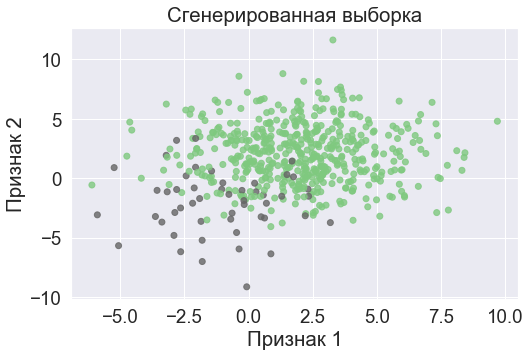

In [3]:
plt.figure(figsize=(8, 5))
plt.title('Сгенерированная выборка')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap='Accent')
plt.grid()
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.show()

Разделим данные на обучающую и тестовую выборку:

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

Выведем размерности выборок:

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((467, 2), (83, 2), (467,), (83,))

### Модель

Определим модель логистической регресии и обучим ее:

In [6]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Выведем коэффициенты модели:

In [7]:
clf.coef_

array([[-0.55679722, -0.80368722]])

Выведем коэффициент перед свободным параметром:

In [8]:
clf.intercept_

array([-2.11685474])

### Результат

График предсказаний вероятности принадлежности классу:

In [9]:
x0_grid, x1_grid = np.meshgrid(np.linspace(-10, 10, 2001), 
                               np.linspace(-10, 10, 2001))
ravel_grid = np.array([x0_grid, x1_grid]).reshape((2, 2001*2001)).T
prob_grid = clf.predict_proba(ravel_grid)
prob_grid = prob_grid[:, 0].reshape((2001, 2001))

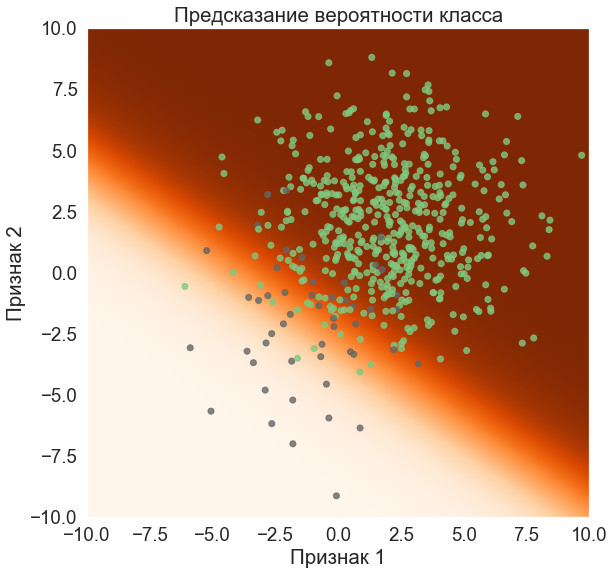

In [10]:
plt.figure(figsize=(9, 9))
plt.pcolormesh(x0_grid, x1_grid, prob_grid, cmap='Oranges')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap='Accent')
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
plt.title('Предсказание вероятности класса');

## Метрики качества классификации

Для бинарной классификации существует множество различных метрик качества. В этом ноутбуке рассмотрим самые основные.

### Accuracy (доля правильных ответов)

[Accuracy в `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

Данная метрика является самой тривиальной метрикой для задачи классификации и представляет собой долю правильных ответов:

$$accuracy(y, \widehat{y}) = \frac{1}{n}\sum\limits_{i=1}^{n} {I\{y_i = \widehat{y}_i\}},$$   
  
где $y$ &mdash; вектор истинных классов, $\widehat{y}$ &mdash; вектор предсказанных классов, $n$ &mdash; количество объектов.

**Достоинство**: в основе метрики $accuracy$ лежит простая интуиция.

**Недостаток**: данная метрика плоха в случае дисбаланса классов, когда представителей одного из класса существенно больше, чем другого.

Рассмотрим пример выборки, в которой $950$ положительных и $50$ отрицательных объектов. Пусть наш классификатор всем объектам выдает класс $1$. Тогда его accuracy будет равен $0.95$, что является очень неплохим результатом. Однако сама модель при этом не имеет особого смысла: она просто возвращает константу при любом входе.

Это означает, что доля правильных ответов сама по себе не несет никакой информации о качестве работы модели, и вместе с ней следует анализировать соотношение классов в выборке.

**Пример вычисления**

Вычислим $accuracy$ для нашей задачи:

In [11]:
accuracy = accuracy_score(y_test, clf.predict(X_test))
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.904


В данной ситуации эта метрика не очень информативна, так как классификатор, предсказывающий всегда 1 класс, имел бы accuracy $\approx 90\%$ 

### Confusion matrix (матрица ошибок)

[Confusion matrix в `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

Рассмотрим  матрицу ошибок (confusion matrix) – матрицу размера $2 \times 2$, $ij$-я позиция которой равна числу объектов $i$-го класса, которым модель присвоила метку $j$-го класса. Данное понятие нужно осознать и запомнить, так как на основе данной матрицы будут введены более сложные метрики.

<img src="https://miro.medium.com/max/1780/1*LQ1YMKBlbDhH9K6Ujz8QTw.jpeg" alt="drawing" width="400"/>

**TN** &mdash; True Negative, количество верно (True) предсказанных объектов среди тех, которым модель присвоила негативный (Negative) класс.  
**FP** &mdash; False Positive, количество неверно (False) предсказанных объектов среди тех, которым модель присвоила позитивный (Positive) класс.  
**FN** &mdash; False Negative, количество неверно (False) предсказанных объектов среди тех, которым модель присвоила негативный (Negative) класс.  
**TP** &mdash; True Positive, количество верно (True) предсказанных объектов среди тех, которым модель присвоила позитивный (Positive) класс.  




Отметим, что в данной терминологии $accuracy$ можно представить через следующую формулу:  
<br>
$$accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

**Пример**

Пусть мы хотим оценить работу спам-фильтра почты. У нас есть $100$ не-спам писем, $90$ из которых наш классификатор определил верно и $10$ спам-писем, $5$ из которых классификатор также определил верно. Будем считать класс не-спам писем отрицательным, а класс спам писем &mdash; положительным. Обозначим количество объектов отрицательного класса $N_0$, а положительного $N_1$, тогда:

$$
N_0 = TN + FP = 100,
\\
N_1 = TP + FN = 10.
$$

Итого:
* Из $100$ не-спам писем $90$ были определены верно $\Rightarrow TN = 90, \; FP = 10$;
* Из $10$ спам писем 5 были определены верно $\Rightarrow TP = 5, \; FN = 5$.

Данная матрица сама по себе является не метрикой, а инструментом, с помощью которого можно ввести более продвинутые метрики. Тем не менее ее полезно визуализировать, так как она является достаточно информативной. 

**Пример вычисления**

Вычислим матрицу ошибок для нашей задачи:

In [12]:
matrix = confusion_matrix(y_test, clf.predict(X_test))
(TN, FP), (FN, TP) = matrix
print(f'TN = {TN}')
print(f'FP = {FP}')
print(f'FN = {FN}')
print(f'TP = {TP}')

TN = 70
FP = 2
FN = 6
TP = 5


### Precision (точность)

[Precision в `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)

Точность (Precision, Positive Predictive Value) показывает какой процент объектов, которые метод посчитал положительными, действительно являются положительными:

$$precision(y, \widehat{y}) = \frac{TP}{TP + FP},$$

где $y$ &mdash; вектор истинных классов, $\widehat{y}$ &mdash; вектор предсказанных классов.


**Пример:**

Рассмотрим задачу предсказания реакции клиента банка на звонок с предложением кредита.
Класс $y = 1$ означает, что клиент возьмет кредит после рекламного звонка, класс $y = -1$, что не возьмет. 
Планируется обзванивать только тех клиентов, которых классификатор отнесет к классу $1$.
Если классификатор имеет высокую точность, то практически все клиенты, которым будет сделано предложение, откликнутся на него.

**Достоинство**: позволяет следить за тем, насколько можно доверять модели, если она предсказывает позитивный класс.

**Недостаток**: не позволяет следить за тем, как много положительных объектов способен распознать классификатор.

Например, мы построили модель, которая присваивает позитивный класс очень малому количеству объектов. $Precision$ у такой модели может быть хорошим, но при этом модель присваивает негативный класс очень большому количеству позитивных объектов. 

**Пример вычисления**

Вычислим $precision$ для нашей задачи:

In [13]:
precision = precision_score(y_test, clf.predict(X_test))
print(f'Precision = {precision:.3f}')

Precision = 0.714


### Recall (полнота)

[Recall в `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)

Полнота (Recall, True Positive Rate) показывает какую долю объектов положительного класса модель классифицировала правильно:

$$recall(y, \widehat{y}) = \frac{TP}{TP + FN},$$

где $y$ &mdash; вектор истинных классов, $\widehat{y}$ &mdash; вектор предсказанных классов.


**Пример:**

Рассмотрим тот же пример предсказания реакции клиента банка на звонок с предложением кредита.<br>
Если классификатор имеет высокую полноту, то предложение будет сделано практически всем клиентам, которые готовы откликнуться на него.

**Достоинство**: позволяет следить за тем, как много положительных объектов способен распознать классификатор. 

**Недостаток**: не позволяет следить за тем, насколько можно доверять модели, если она предсказывает позитивный класс.

*Замечание 1.*

1. Легко построить модель с $recall = 1$. Она все объекты относит к классу $1$, но при этом $precision$ может быть очень низким. 
2. Нетрудно построить модель с $precision$ близким к $1$. Она относит к классу $1$ только те объекты, в которых точно уверена, при этом $recall$ может быть низким. 

*Замечание 2.*

Отметим, что точность и полнота не зависят от соотношения размеров классов. Даже если объектов положительного класса на порядки меньше, чем объектов отрицательного класса, данные показатели будут корректно отражать качество работы модели.

**Пример вычисления**

Вычислим $recall$ для нашей задачи:

In [14]:
recall = recall_score(y_test, clf.predict(X_test))
print(f'Recall = {recall:.3f}')

Recall = 0.455


### $F_1$-мера
[$F_1$-мера в `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)


Хотелось бы получить один критерий, который учитывал бы в себе и точность, и полноту. Существует несколько способов получить один критерий качества на основе точности и полноты.
Один из них &mdash; $F_1$-мера, гармоническое среднее точности и полноты:

$$F_1 = \frac{ 2 \cdot precision \cdot recall}{precision + recall}$$

Среднее гармоническое обладает важным свойством &mdash; оно близко к нулю, если хотя бы один из аргументов близок к нулю.
При этом $F_1$ достигает максимума при $precision = 1$ и $recall = 1$.

*Замечание.*

Иногда эту метрику просто называют $F$-мерой.

Рассмотрим другие методы агрегации $precision$ и $recall$. Они не используются, но полезно увидеть их недостатки в сравнении со средним гармоническим.

1. Среднее арифметическое
$$A = \frac{precision + recall}{2}$$
**Недостатки:** <br>
Пусть есть выборка, в которой $10\%$ объектов &mdash; класс $0$. <br>
Модель $a_1$ всегда выдает класс 1 $\Rightarrow precision_{1} = 0.1, recall_{1} = 1$ <br>
$\Rightarrow A_1 = 0.55$ <br>
Модель $a_2$ имеет $precision_{2} = 0.55, recall_{1} = 0.55$ <br>
$\Rightarrow A_2 = 0.55$ <br>
Среднее арифметическое обеих моделей одинаково, однако первая модель совсем бесполезная, а вторая хоть как-то умеет различать классы. 


2. Минимум
$$M = \min(precision, recall)$$
Максимум достигается при $precision = 1$ и $recall = 1$. <br>
**Недостатки:** <br>
Пусть модель $a_1$ имеет $precision_{1} = 0.4, recall_{1} = 0.9$ <br>
$\Rightarrow M_1 = 0.4$ <br>
А модель $a_2$ имеет $precision_{2} = 0.4, recall_{2} = 0.5$ <br>
$\Rightarrow M_2 = 0.4$ <br>
Минимумы двух моделей одинаковы, однако очевидно, что первая модель гораздо лучше.

Можно заметить, что $F_1$-мера по сути является сглаженной версией минимума из точности и полноты и поэтому она лишена минусов двух рассмотренных метрик.

Визуализируем различные методы агрегации $precision$ и $recall$.

In [15]:
precision_grid = np.linspace(0, 1, 100)[1:]
recall_grid = np.linspace(0, 1, 100)[1:]
precision_mesh, recall_mesh = np.meshgrid(precision_grid, recall_grid)
mean_values = (precision_mesh + recall_mesh) / 2
min_values = np.minimum(precision_mesh, recall_mesh)
f1_values = 2*precision_mesh*recall_mesh / (precision_mesh + recall_mesh)

levels = np.linspace(0, 1, 15)

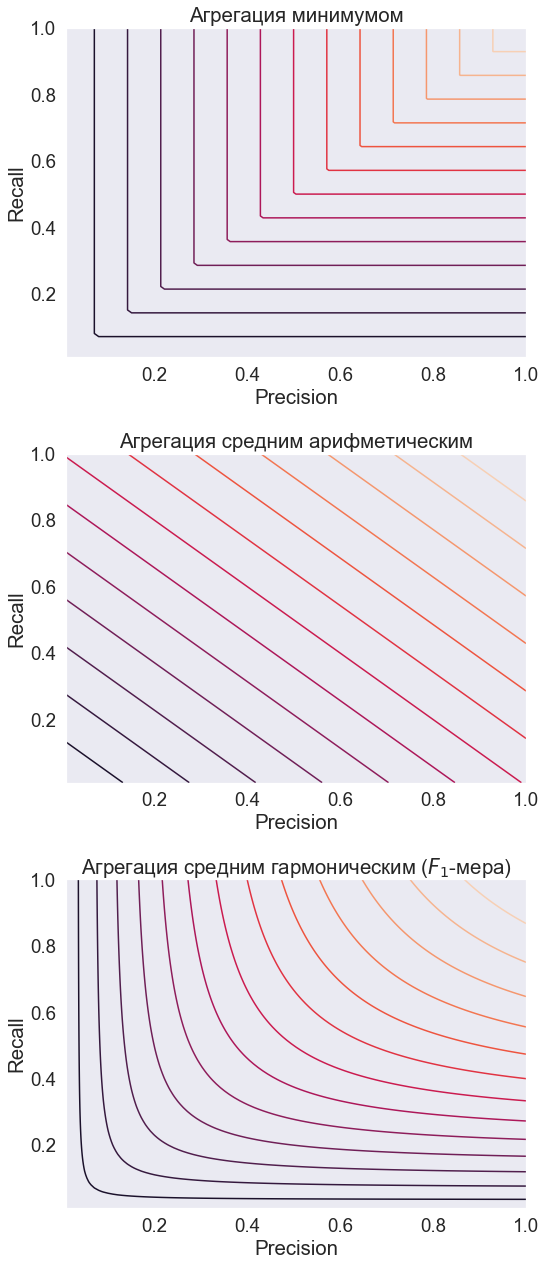

In [16]:
plt.figure(figsize=(8, 18))

plt.subplot(3, 1, 1)
plt.contour(precision_grid, recall_grid, min_values, levels=levels)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Агрегация минимумом')

plt.subplot(3, 1, 2)
plt.contour(precision_grid, recall_grid, mean_values, levels=levels)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Агрегация средним арифметическим')

plt.subplot(3, 1, 3)
plt.contour(precision_grid, recall_grid, f1_values, levels=levels)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Агрегация средним гармоническим ($F_1$-мера)')

plt.tight_layout()
plt.show()

**Пример вычисления**

Вычислим $F_1$-меру для нашей задачи:

In [17]:
f1 = f1_score(y_test, clf.predict(X_test))
print(f'F1 = {f1:.3f}')

F1 = 0.556


## Случай линейно разделимых классов

Теперь рассмотрим случай, когда классы линейно разделимы:

In [18]:
X, y = make_blobs(n_samples=(500, 50), random_state=42)

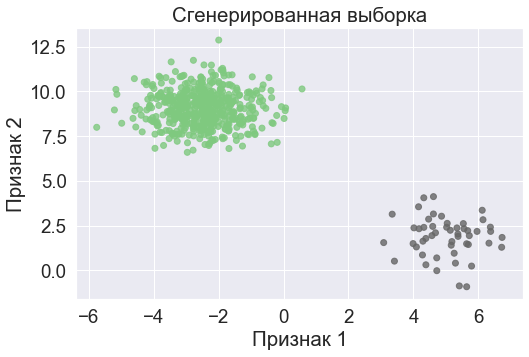

In [19]:
plt.figure(figsize=(8, 5))
plt.title('Сгенерированная выборка')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap='Accent')
plt.grid()
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.show()

Разделим данные на обучающую и тестовую выборку:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

Выведем размерности выборок:

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((467, 2), (83, 2), (467,), (83,))

Обучим модель:

In [22]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

И посмотрим на метрики:

In [23]:
predicted = clf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
precision = precision_score(y_test, predicted)
recall = recall_score(y_test, predicted)
f1 = f1_score(y_test, predicted)
print(f'Accuracy = {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 = {f1:.3f}')

Accuracy = 1.000
Precision: 1.000
Recall: 1.000
F1 = 1.000


In [24]:
x0_grid, x1_grid = np.meshgrid(np.linspace(-10, 10, 2001), 
                               np.linspace(-2, 12, 2001))
ravel_grid = np.array([x0_grid, x1_grid]).reshape((2, 2001*2001)).T
prob_grid = clf.predict_proba(ravel_grid)
prob_grid = prob_grid[:, 0].reshape((2001, 2001))

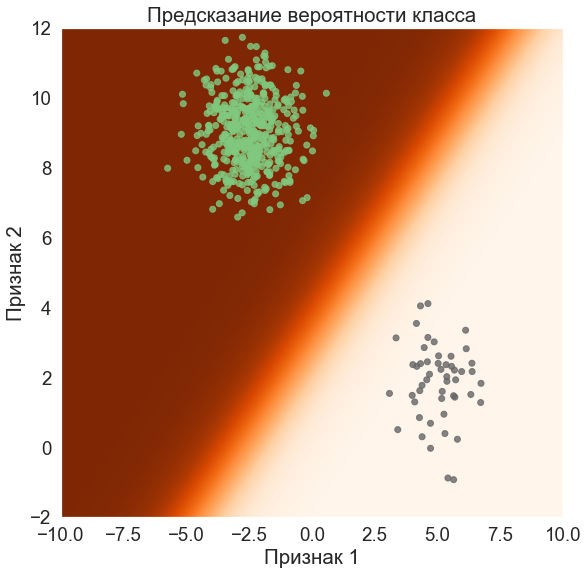

In [25]:
plt.figure(figsize=(9, 9))
plt.pcolormesh(x0_grid, x1_grid, prob_grid, cmap='Oranges')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap='Accent')
plt.xlim((-10, 10)), plt.ylim((-2, 12))
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.title('Предсказание вероятности класса');

Видим, что классы разделены правильно. Вопреки теории здесь не возникло переобучения, при котором оценка вероятностей всех классов будет $0$ или $1$. Причина в том, что по умолчанию используется регуляризация, управлять которой можно с помощью параметра `C`.